In [52]:
import cv2
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from scipy.signal import find_peaks
from skimage.feature import canny


In [53]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [54]:
def gamma_correction(image, gamma):
    # Normalize pixel values to the range [0, 1]
    normalized_image = image / 255.0
    
    # Apply gamma correction
    corrected_image = np.power(normalized_image, gamma)
    
    # Denormalize the corrected image to the original range [0, 255]
    corrected_image = (corrected_image * 255).astype(np.uint8)
    
    return corrected_image

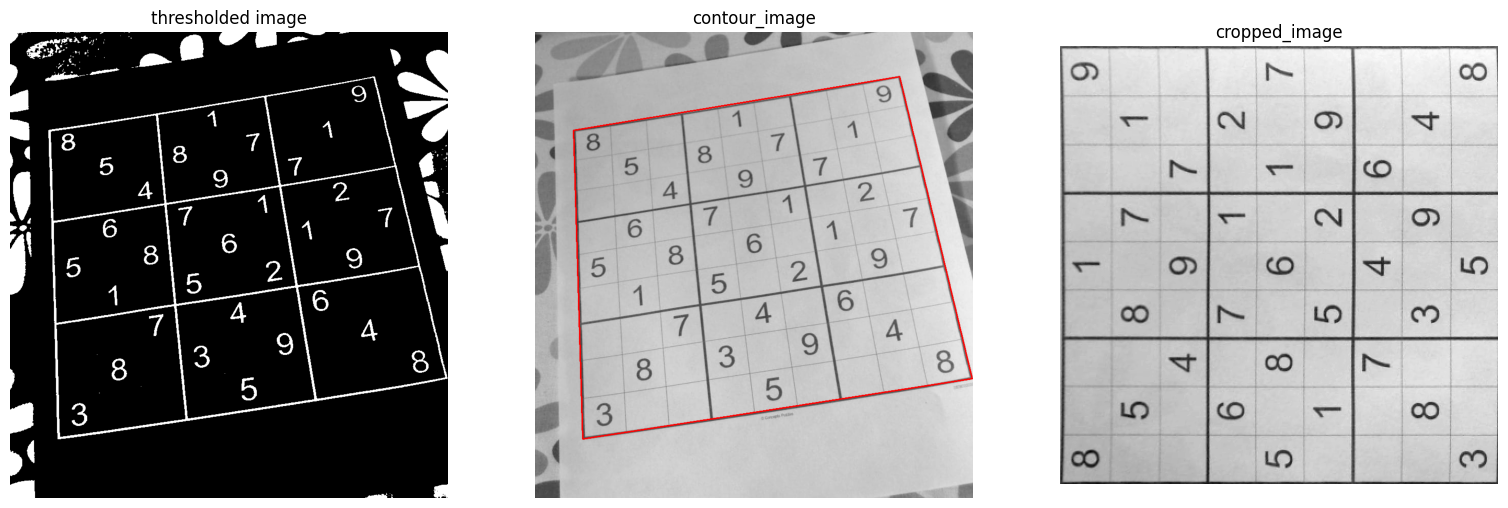

In [145]:
# read image
img = cv2.imread('./input_sample_3.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


gamma = 0.889
img = gamma_correction(img,gamma)

# get histogram and find peaks
hist, bins = np.histogram(img.flatten(), bins=256, range=[0, 256])
peaks, _ = find_peaks(hist, distance=30,height=1000, prominence=100)

# Plot the histogram and highlight the peaks
# plt.plot(hist)
# plt.plot(peaks, hist[peaks], 'ro')  # Mark peaks with red dots
# plt.title('Image Histogram with Peaks')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Frequency')
# plt.show()

# segmentation
binaryThreshold = (peaks[0]+peaks[1]) /2
binary_image = 255 - cv2.threshold(img, binaryThreshold, 255, cv2.THRESH_BINARY)[1]

erosionKernel = np.ones((4, 4), np.uint8)
dialationKernel = np.ones((7, 7), np.uint8)


# binary_image = cv2.erode(binary_image, erosionKernel, iterations=3)
# closed_image = cv2.dilate(binary_image, dialationKernel, iterations=3)
# binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, erosionKernel,iterations=1)




# newLines = []
# done = False  # Initialize done as a global variable

# i = len(lines) - 1
# while i >= 0:
#     j = i - 1
#     done = False  # Reset done for each iteration of the outer loop
#     while j >= 0:
#         if (abs(lines[i][0][0] - lines[j][0][0]) < 100) and (abs(lines[i][0][1] - lines[j][0][1]) < 0.1):
#             done = True
#         j -= 1
#     if not done:
#         newLines.append(lines[i])
#     i -= 1

# print(newLines)
# print(len(lines))
# print(len(newLines))

contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = cv2.cvtColor(img.copy(),cv2.COLOR_GRAY2BGR)
# cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)

rectangles = []

for contour in contours:
    # Approximate the contour to a polygon
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Check if the polygon has 4 vertices (a square)
    if len(approx) == 4:
        # Calculate the bounding rectangle
        x, y, w, h = cv2.boundingRect(approx)

        # Ensure that the rectangle is approximately square
        aspect_ratio = float(w) / h
        # if 0.4 <= aspect_ratio <= 1.6:
            # Draw the rectangle on the original image
        rectangles.append((w*h,approx))
        # cv2.drawContours(contour_image, [approx], 0, (0, 255, 0), 2)

rectangles.sort(reverse=True,key=lambda x: x[0])
cv2.drawContours(contour_image, [rectangles[0][1]], 0, (255, 0, 0), 2)

# Define the original four points (source points) - specify them in the order top-left, top-right, bottom-right, bottom-left
original_points = np.array([rectangles[0][1][0], rectangles[0][1][3], rectangles[0][1][2], rectangles[0][1][1]], dtype=np.float32)

# Define the new four points (destination points)
new_points = np.array([[0, 0], [400, 0], [400, 400], [0, 400]], dtype=np.float32)

# Calculate the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(original_points, new_points)

# Apply the perspective transformation to the image
result = cv2.warpPerspective(img, matrix, (400, 400))


# edges = cv2.Canny(binary_image, 50, 200, apertureSize=3)
# lines = cv2.HoughLines(edges, 1, np.pi/180, 150)
# for r_theta in lines:
#     arr = np.array(r_theta[0], dtype=np.float64)
#     r, theta = arr
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*r
#     y0 = b*r
#     x1 = int(x0 + 10000*(-b))
#     y1 = int(y0 + 10000*(a))
#     x2 = int(x0 - 10000*(-b))
#     y2 = int(y0 - 10000*(a))
#     cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

show_images([binary_image,contour_image,result],['thresholded image','contour_image','cropped_image'])